# WeatherPy
----

In [2]:
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests

In [3]:
import citipy_c as ct

Import a custom modification of citipy, stored in my project folders

### The following lines are for initially generating the data. If you instead want to use the previously generated data, go down to the cell labeled as for reading in previous data.

## Generate Cities List

In order to generate cities, I will be creating a random latitude and longitude, and passing them into citipy's nearest_city funtion.

This method has a dramatic flaw - it will generate cities which massively favor the coastline. While that might be good for looking for a vacation location, it introduces some clear bias in how I analyze the relationship between weather and longitude.

In order to combat this, I have modified my local version of citipy to include a lat and lng in the class city.

In [4]:
#A brief lambda function to make my later conditional statements tidier
absCheck = lambda x, y: abs(abs(x) - abs(y))

In [7]:
#Create a list of dictionairies with data about found cities.
city_list=[]
while len(city_list) < 1200:
    row = {}
    #Generate a random latitude and longitude
    latitude = random.randint(-90,90)
    longitude = random.randint(-180, 180)
    city = ct.nearest_city(latitude, longitude)
    #This will test that the found city is within a 138 by 119 mile rectangle around the test point.
    if (absCheck(city.lat, latitude) <= 1) & (absCheck(city.lng, longitude) <= 1):
        row['name'] = city.city_name
        row['country code'] = city.country_code
        row['lat'] = round(city.lat, 3)
        row['lng'] = round(city.lng, 3)
        city_list.append(row)
#Turn my list of dictionaries into a dataframe.
city_df = pd.DataFrame(data=city_list).drop_duplicates()
print(len(city_df))
city_df.head()

1108


,name,country code,lat,lng
0,menongue,ao,-14.662,17.688
1,wawa,ca,48.000,-84.783
2,sainte-suzanne,re,-20.900,55.617
3,edson,ca,53.583,-116.417
4,fez,ma,34.037,-5.000


And now a quick scatterplot of the generated cities latitude and longitude, to verify that distribution has worked as intended.

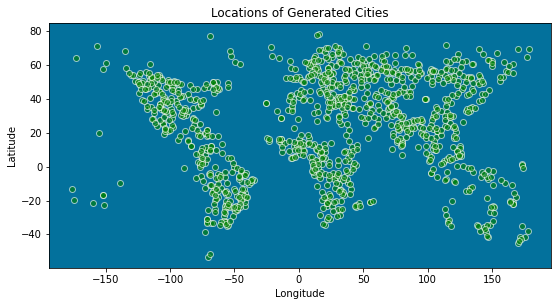

In [8]:
loc_fig, loc_ax = plt.subplots(figsize=(9,4.5))
loc_ax.set_title('Locations of Generated Cities')
loc_ax.set_xlabel('Longitude')
loc_ax.set_ylabel('Latitude')
loc_ax.set_facecolor('xkcd:ocean blue')
loc_ax.scatter( city_df['lng'], city_df['lat'],color='green', edgecolors='white', alpha=0.6)
plt.show()

As we can see, distribution is still not quite uniform - there's very few datapoints from areas that are largely uninhabitable, like the sahara desert and the himilayas. This data could be valuable, as all of these represent extreme climates which could challenge models we generate. However, we would likely need to completely rethink our approach to generating datapoints and forgo finding cities alltogether.

Instead, I will reframe the problem as understanding how latitude affects weather in human habitable environments. 

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [9]:
from api_keys import weather_api_key as wak
import time

In [10]:
#this function allows me to average different data across a 24 hour period that is returned in the json.
def dayAverages(day, target):
    target_ave = 0
    for hour in day:
        target_ave += hour[target]
    target_ave = target_ave/len(day)
    return round(target_ave,3)

In [11]:
weather_list = []
for city in city_df.itertuples():
    #I iterate across my dataframe with itertuples.
    #Because I am working with tuples, I pass numberic indices for reference.
    print(f'now printing city #{city[0]}: {city[1]}')
    weather_dict = {}
    lat = city[3]
    lng = city[4]
    #Set time of query to one day ago
    tm = int(time.time() - 86400)
    #define the output units [standard, metric, or imperial]
    units='imperial'
    search_url = f'http://api.openweathermap.org/data/2.5/onecall/timemachine?lat={lat}&lon={lng}&dt={tm}&units={units}&appid={wak}'
    #Query the data from openweathermap
    response = requests.get(search_url).json()
    response
    weather_dict['name'] = city[1]
    #Get an average temperature for all the hours yesterday.
    try:
        targets=['temp', 'humidity', 'clouds', 'wind_speed']
        for target in targets:
            weather_dict[target] = dayAverages(response['hourly'], target)
    except Exception as e:
        print('Operation failed: ' + str(e))
    weather_list.append(weather_dict)
        

weather_df = pd.DataFrame(data=weather_list)
weather_df.head()

now printing city #0: menongue
now printing city #1: wawa
now printing city #2: sainte-suzanne
now printing city #3: edson
now printing city #4: fez
now printing city #5: asimion
now printing city #6: moyale
now printing city #7: tres picos
now printing city #8: zigong
now printing city #9: mangan
now printing city #10: campbell river
now printing city #11: zhob
now printing city #12: poronaysk
now printing city #13: ortigueira
now printing city #14: malindi
now printing city #15: alcaniz
now printing city #16: namtsy
now printing city #17: stoyba
now printing city #18: holetown
now printing city #19: hunza
now printing city #20: leticia
now printing city #21: sedkyrkeshch
now printing city #22: alta floresta
now printing city #23: hay river
now printing city #24: arraial do cabo
now printing city #25: ask
now printing city #26: omura
now printing city #27: matinha
now printing city #28: is
now printing city #29: south yuba city
now printing city #30: lewisporte
now printing city #31: 

,name,temp,humidity,clouds,wind_speed
0,menongue,59.600417,28.500000,0.000000,5.144583
1,wawa,61.703333,68.375000,21.000000,4.986250
2,sainte-suzanne,67.718750,75.416667,56.041667,18.460833
3,edson,64.175000,62.583333,26.500000,7.240417
4,fez,96.567917,12.666667,33.291667,8.680833


In [12]:
len(weather_df)

1108

In [29]:
weather_df_2 = weather_df.merge(city_df, on='name', how = 'outer')
weather_df_2.iloc[:,1:5] = weather_df_2.iloc[:,1:5].apply(lambda x: round(x,3))

In [30]:
#Save the data to a csv
weather_df_2.to_csv('Results/weather_data.csv', index=False)

# Line to Read in the Previous Data

In [5]:
#Alternative to the full regeneration of the dataset, read in the saved csv.
#weather_df_2 = pd.read_csv('Results/weather_data.csv')

In [7]:
weather_df_2.head()

,name,temp,humidity,clouds,wind_speed,country code,lat,lng
0,menongue,59.600,28.500,0.000,5.145,ao,-14.662,17.688
1,wawa,61.703,68.375,21.000,4.986,ca,48.000,-84.783
2,sainte-suzanne,67.719,75.417,56.042,18.461,re,-20.900,55.617
3,edson,64.175,62.583,26.500,7.240,ca,53.583,-116.417
4,fez,96.568,12.667,33.292,8.681,ma,34.037,-5.000


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [32]:
len(weather_df_2.loc[weather_df_2['humidity'] > 100])

0

There are no cities in my dataframe which have a humidity of over 100%

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

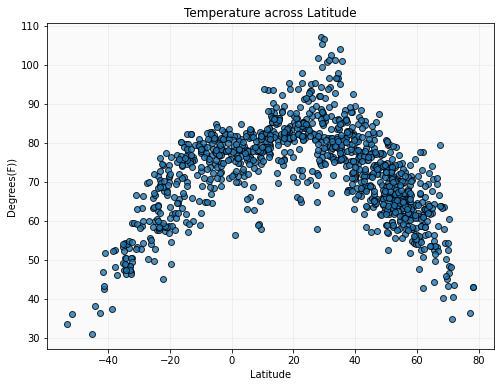

In [100]:
fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.set_title('Temperature across Latitude')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Degrees(F))')
ax1.set_facecolor('#FAFAFA')
plt.grid(alpha=0.2)
ax1.scatter(weather_df_2['lat'], weather_df_2['temp'], edgecolor="black", alpha = 0.8)
plt.show()
fig1.savefig('Results/TemperaturevsLatitude.png')

There is a strong relationship between increasing latitude and decreasing temperature. It is likely that the high values around 30 degrees of latitude are made more extreme due to summer fluctuation.

## Latitude vs. Humidity Plot

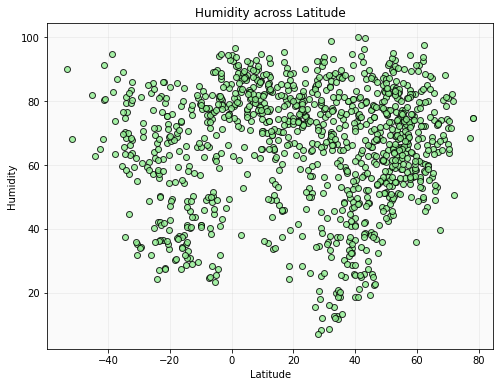

In [101]:
fig2, ax2 = plt.subplots(figsize=(8,6))
ax2.set_title('Humidity across Latitude')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Humidity')
ax2.set_facecolor('#FAFAFA')
plt.grid(alpha=0.2)
ax2.scatter(weather_df_2['lat'], weather_df_2['humidity'], edgecolor="black", color='lightgreen', alpha = 0.8)
plt.show()
fig2.savefig('Results/HumidityvsLatitude.png')

Humidity and Latitude have a less straightforward relationship. It seems as latitude increases, there are few regions that have low humidity. 

## Latitude vs. Cloudiness Plot

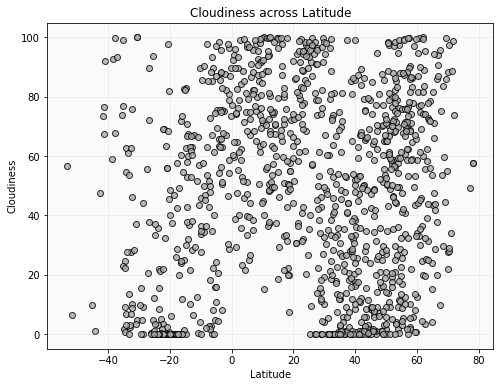

In [102]:
fig3, ax3 = plt.subplots(figsize=(8,6))
ax3.set_title('Cloudiness across Latitude')
ax3.set_xlabel('Latitude')
ax3.set_ylabel('Cloudiness')
ax3.set_facecolor('#FAFAFA')
plt.grid(alpha=0.2)
ax3.scatter(weather_df_2['lat'], weather_df_2['clouds'], edgecolor="black", color='darkgrey', alpha = 0.8)
plt.show()
fig3.savefig('Results/CloudinessvsLatitude.png')

There does not seem to be any relation in the data between Cloudiness and Latitude.

## Latitude vs. Wind Speed Plot

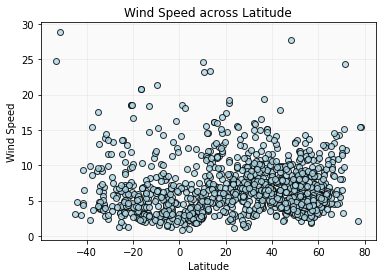

In [53]:
fig3, ax3 = plt.subplots(figsize=(8,6))
ax3.set_title('Wind Speed across Latitude')
ax3.set_xlabel('Latitude')
ax3.set_ylabel('Wind Speed')
ax3.set_facecolor('#FAFAFA')
plt.grid(alpha=0.2)
ax3.scatter(weather_df_2['lat'], weather_df_2['wind_speed'], edgecolor="black", color='lightblue', alpha = 0.8)
plt.show()
fig3.savefig('Results/WindvsLatitude.png')

There is no discernable relationship between wind speed and latitude.

### Temperature Plotted Across a Globe

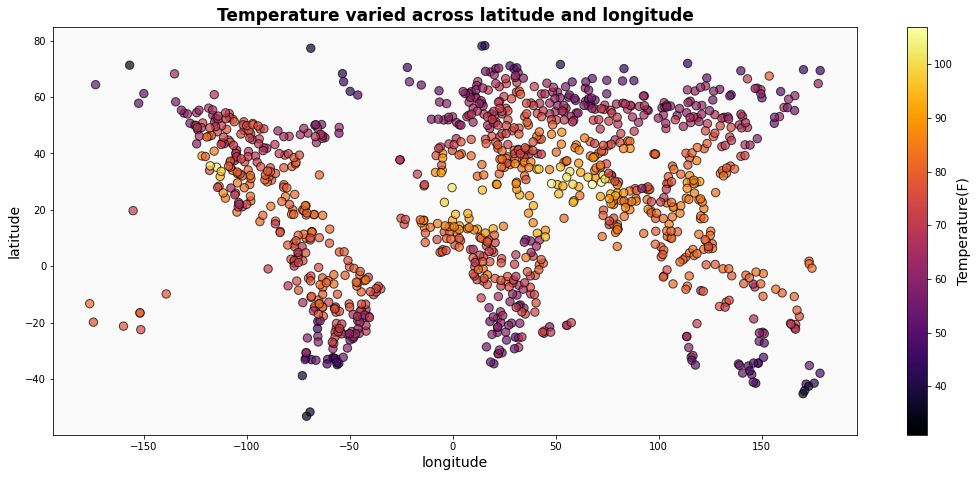

In [99]:
fig4, ax4 = plt.subplots(figsize=(18,7.5))
ax4.set_title('Temperature varied across latitude and longitude', weight='bold', size=17)
ax4.set_xlabel('longitude', size=14)
ax4.set_ylabel('latitude', size=14)
ax4.set_facecolor('#fafafa')
ax4.scatter(weather_df_2['lng'], weather_df_2['lat'], edgecolor="black", c=weather_df_2['temp'], cmap = 'inferno', s=70, alpha = 0.7)
normal = matplotlib.colors.Normalize(vmin=weather_df_2['temp'].min(), vmax=weather_df_2['temp'].max())
cbar = fig4.colorbar(cm.ScalarMappable(norm=normal, cmap='inferno'), ax=ax4)
cbar.set_label('Temperature(F)', rotation=90, size=14)
plt.show()
fig4.savefig('Results/TemperatureWorld.png')

As an extra visualization, I made a scatterplot that varies with temperature, and shows latitude and longitude. This allows you to roughly see the trends towards hotter regions near the equator, as well as the extremely high temperatures in arid summer locations when this sample was taken. I added a colorbar to scale the temperature.

## Linear Regression

In [12]:
import scipy.stats as stats

In [8]:
weather_df_2.head()

,name,temp,humidity,clouds,wind_speed,country code,lat,lng
0,menongue,59.600,28.500,0.000,5.145,ao,-14.662,17.688
1,wawa,61.703,68.375,21.000,4.986,ca,48.000,-84.783
2,sainte-suzanne,67.719,75.417,56.042,18.461,re,-20.900,55.617
3,edson,64.175,62.583,26.500,7.240,ca,53.583,-116.417
4,fez,96.568,12.667,33.292,8.681,ma,34.037,-5.000


In [ ]:
#  linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
s_slope, s_int, s_r, s_p, s_std_err = st.linregress(cap_av_weight_tumor['Weight (g)'], cap_av_weight_tumor['Tumor Volume (mm3)'])
s_fit = s_slope * cap_av_weight_tumor['Weight (g)'] + s_int

sfig, sax = plt.subplots()
sax.scatter(cap_av_weight_tumor['Weight (g)'], cap_av_weight_tumor['Tumor Volume (mm3)'])
sax.plot(cap_av_weight_tumor['Weight (g)'], s_fit, '--', color = 'lightblue')
sax.set_title("Average Weight vs Tumor Size for the Capomulin group")
sax.set_ylabel('Tumor Volume(mm3)')
sax.set_xlabel('Weight (g)')
plt.show()

#### Split the dataframe into northern and southern hemispheres.

In [37]:
#make the column names nicer
weather_df_2.rename(columns={'temp': 'Temperature', 
                    'humidity': 'Humidity %',
                    'clouds':'Cloudiness %',
                    'wind_speed': 'Wind Speed (mph)'
                    }, inplace=True)
#Subset the data into northern and southern points based on latitude and longitude. 
northern_weather = weather_df_2.loc[(weather_df_2['lat'] >= 0)]
#I make the equator inclusive in both northern and southern data because I am not actually worried about overlapping data points, I just want to observe trends.
southern_weather = weather_df_2.loc[weather_df_2['lat'] <= 0]
#verify that they subset successfully
print(northern_weather['lat'].min(), southern_weather['lat'].max())

0.085 -0.183


In [76]:
def north_south_lin(key):
    #create a linear model for the northern and southern hemispheres
    n = stats.linregress(northern_weather['lat'], northern_weather[key])
    n_line = n.slope * northern_weather['lat'] + n.intercept
    s = stats.linregress(southern_weather['lat'], southern_weather[key])
    s_line = s.slope * southern_weather['lat'] + s.intercept
    #Create a two graph figure
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
    axlist = [ax1, ax2]
    #Set the overall title for the two graphs
    fig.suptitle(f'{key} varied by Latitude', size = 20, weight ='bold')
    #Set common figure formatting
    for ax in axlist:
        ax.set_xlabel('Latitude', fontsize = 16)
        ax.set_ylabel(key, fontsize = 16)
        ax.set_facecolor('#FAFAFA')
        ax.grid(alpha = 0.2)
    #Make Northern Hemisphere graph
    ax1.set_title('Northern Hemisphere', fontsize=16)
    ax1.plot(northern_weather['lat'], n_line, '--',color = 'darkgreen', linewidth = 2 )
    #Set text in the bottom left of the graph
    ax1.text(1, northern_weather[key].min(), f'Correlation: {round(n.rvalue, 2)}', fontsize=14, backgroundcolor = '#FAFAFA')
    ax1.scatter(northern_weather['lat'], northern_weather[key], edgecolor='black', alpha=0.8)
    #Make Southern Hemisphere Graph
    ax2.set_title('Southern Hemisphere', fontsize=16)
    ax2.plot(southern_weather['lat'], s_line, '--',color = 'darkgreen', linewidth = 2 )
    #Set text in the bottom left of the graph
    ax2.text(-50, southern_weather[key].min(), f'Correlation: {round(s.rvalue, 2)}', fontsize=14, backgroundcolor = '#FAFAFA') 
    ax2.scatter(southern_weather['lat'], southern_weather[key], edgecolor='black', alpha=0.8)
    plt.show()

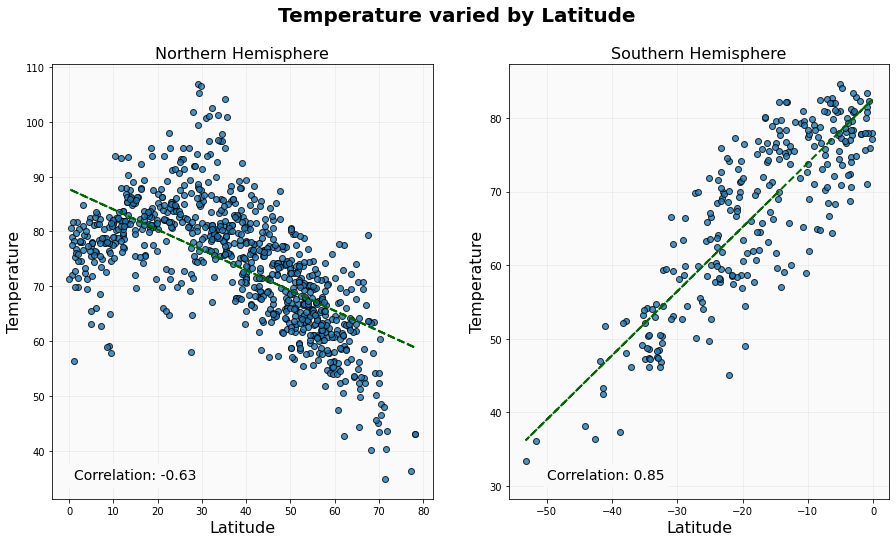

In [77]:
north_south_lin('Temperature')

Temperature is shown to have a very strong relationship with latitude.

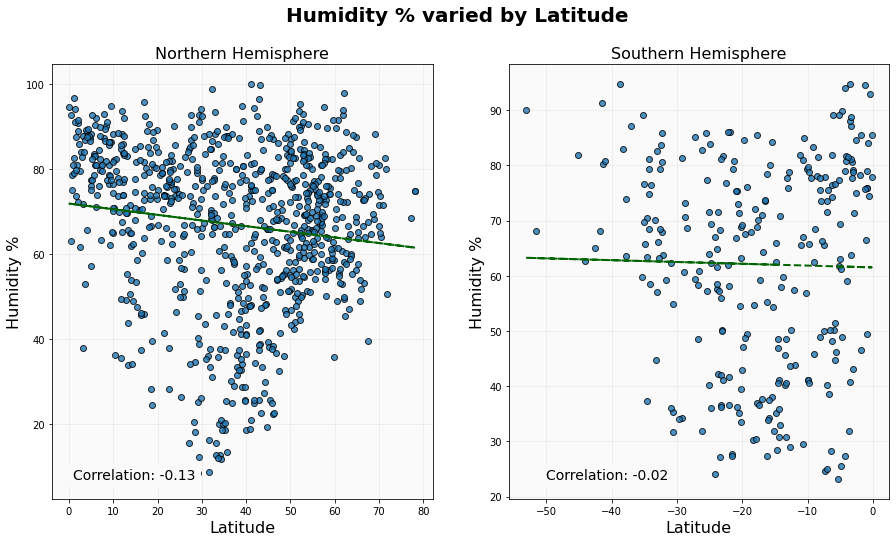

In [78]:
north_south_lin('Humidity %')

Humidity, in contrast, is shown to have a very weak correlation if any.

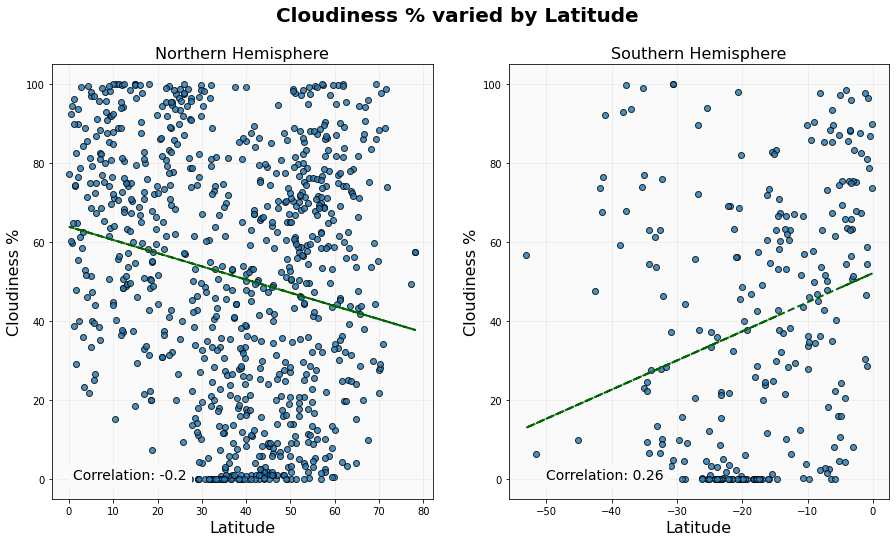

In [79]:
north_south_lin('Cloudiness %')

Cloudiness does seem to be weakly correlated with latitude, with cloudiness increasing as you approach the equator. 

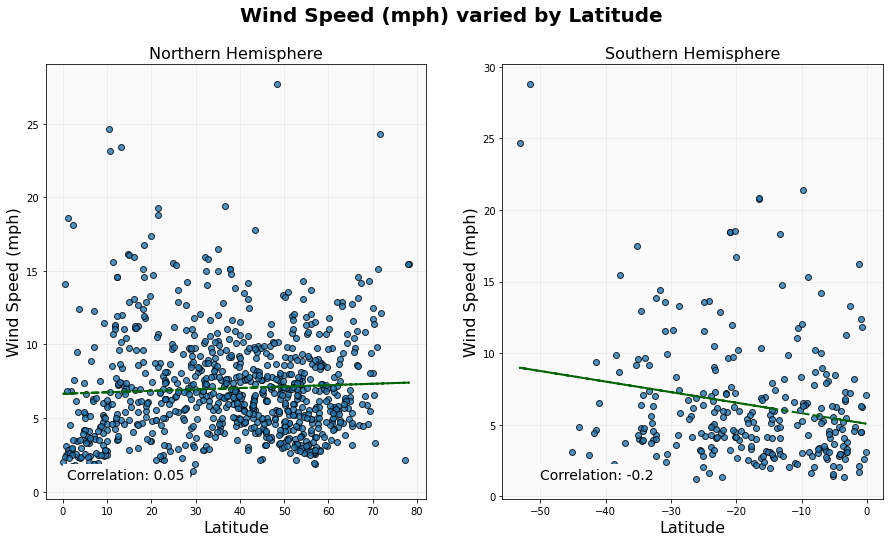

In [81]:
north_south_lin('Wind Speed (mph)')

Wind Speed does not have any convincing correlation based upon latitude.